In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from IPython.display import display, HTML

# Download data

In [0]:
kaggle_username = "Your kaggle name"
api_key = "Your Api key"

import os
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = api_key
!kaggle competitions download -c sberbank-russian-housing-market

  0% 0.00/66.5k [00:00<?, ?B/s]
100% 66.5k/66.5k [00:00<00:00, 58.3MB/s]
  0% 0.00/18.6k [00:00<?, ?B/s]
100% 18.6k/18.6k [00:00<00:00, 17.9MB/s]
  0% 0.00/4.46M [00:00<?, ?B/s]
100% 4.46M/4.46M [00:00<00:00, 40.8MB/s]
 53% 9.00M/17.1M [00:00<00:00, 23.3MB/s]
100% 17.1M/17.1M [00:00<00:00, 31.7MB/s]
data_dictionary.txt: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!rm -r sample_data
!unzip -o train.csv.zip
!rm train.csv.zip
!unzip -o macro.csv.zip
!rm macro.csv.zip
!unzip -o sample_submission.csv.zip
!rm sample_submission.csv.zip
!unzip -o test.csv.zip
!rm test.csv.zip
!rm -r __MACOSX

rm: cannot remove 'sample_data': No such file or directory
Archive:  train.csv.zip
  inflating: train.csv               
   creating: __MACOSX/
  inflating: __MACOSX/._train.csv    
Archive:  macro.csv.zip
  inflating: macro.csv               
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  test.csv.zip
  inflating: test.csv                
  inflating: __MACOSX/._test.csv     


In [0]:
train = pd.read_csv('./train.csv', index_col='id')
test = pd.read_csv('./test.csv', index_col='id')
train['timestamp'] = train['timestamp'].apply(pd.to_datetime)

In [0]:
def num_houses_with_bigger_column_value (column_name, value):
  return len(train[train[column_name] > value].index)

def num_houses_with_less_column_value (column_name, value):
  return len(train[train[column_name] < value].index)

In [0]:
def plot_feature_kde(column_name, min_value, max_value):
  data = train[column_name]
  data = data.where(data.notnull(), axis=0)
  data = data[(min_value <= data) & (data <= max_value)]
  ax = sns.kdeplot(data=data, shade=True)
  ax.set(xlabel= column_name, ylabel='density')

def plot_regplot(column_name1, column_name2, col1_min, col1_max, col2_min, col2_max, alpha=0.1):
  reg_plot_data = train[[column_name1, column_name2]]
  reg_plot_data = reg_plot_data[(col1_min <= train[column_name1]) & (train[column_name1] <= col1_max) \
                                & (col2_min <= train[column_name2]) & (train[column_name2] <= col2_max)]
  sns.regplot(x=reg_plot_data[column_name1], y=reg_plot_data[column_name2], \
              scatter_kws={'alpha':alpha})

def plot_features_jointplot(column_name1, column_name2, col1_min, col1_max, \
                            col2_min, col2_max, alpha=0.1):
  data = train.loc[:, [column_name1, column_name2]]
  data=data[data.notnull().all(axis=1)]
  data = data[(col1_min <= data[column_name1]) & (data[column_name1] <= col1_max) \
              & (col2_min <= data[column_name2]) & (data[column_name2] <= col2_max)]
  sns.jointplot(column_name1, column_name2, data=data, kind="kde", space=0, color="b", \
                scatter_kws={'alpha':alpha})

def plot_lmplot(column_name1, column_name2, hue, col1_min, col1_max, \
                            col2_min, col2_max, alpha=0.1):
  data = train.loc[:, [column_name1, column_name2, hue]]
  data=data[data.notnull().all(axis=1)]
  data = data[(col1_min <= data[column_name1]) & (data[column_name1] <= col1_max) \
              & (col2_min <= data[column_name2]) & (data[column_name2] <= col2_max)]
  sns.lmplot(x=column_name1, y=column_name2, hue=hue, data=data, scatter_kws={'alpha':alpha})

def plot_distplot(column_name):
  sns.distplot(a=train[column_name], kde=False)

# Understanding missing values

In [0]:
numeric_nan_info = train._get_numeric_data().isna().sum()
print(len(numeric_nan_info[numeric_nan_info > 0]), 'numeric columns have missing values.\n')
numeric_nan_info[numeric_nan_info > 0]

51 numeric columns have missing values.



life_sq                                   6383
floor                                      167
max_floor                                 9572
material                                  9572
build_year                               13605
num_room                                  9572
kitch_sq                                  9572
state                                    13559
preschool_quota                           6688
school_quota                              6685
hospital_beds_raion                      14441
raion_build_count_with_material_info      4991
build_count_block                         4991
build_count_wood                          4991
build_count_frame                         4991
build_count_brick                         4991
build_count_monolith                      4991
build_count_panel                         4991
build_count_foam                          4991
build_count_slag                          4991
build_count_mix                           4991
raion_build_c

In [0]:
numeric_features = train._get_numeric_data().columns
categorical_features = set(train.columns) - set(numeric_features)
categorical_features_nan_info = train[categorical_features].isna().sum()
print(len(categorical_features_nan_info[categorical_features_nan_info > 0]), 'categorical columns have missing values.\n')
categorical_features_nan_info[categorical_features_nan_info > 0]

0 categorical columns have missing values.



Series([], dtype: int64)

In [0]:
train.describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,3.047100e+04,30471.000000,30471.000000,30471.000000,30471.000000,23783.000000,30471.000000,30471.000000,23786.000000,30471.000000,30471.000000,16030.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,...,29480.000000,29480.000000,29480.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30293.000000,30471.000000,3.047100e+04,30471.000000,3.047100e+04,30471.000000,30174.000000,30174.000000,30174.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04
mean,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,1.765705e+07,84056.425552,0.218922,0.118871,5140.026156,3271.272464,4.065111,5354.269699,8324.970739,4.705031,0.109678,1190.738677,1.320895,0.138295,6.635030,2.896393,0.286732,4.200978,8.253454,1.463062e+05,67207.789603,79098.662105,11178.809491,5723.853106,5455.013948,53667.908897,27253.585803,26414.414821,19209.707164,5811.618162,13398.167438,...,765.900619,1283.334756,1024.617808,7.274622,27.782055,30.450297,26.685078,13.320108,4.646516,0.707131,6.122674,12.287979,0.199075,3.876440,20.239310,2.319944,22.769557,10.348669,71.356240,1.401057e+06,30.131863,1.173871e+06,265.528470,765.098467,1278.280635,1021.689513,17.806898,66.195530,73.442421,63.469660,32.058318,10.783860,1.771783,15.045552,30.251518,0.442421,8.648814,52.796593,5.987070,7.123035e+06
std,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,2.064961e+07,57871.285899,0.175090,0.118688,3816.625140,2169.759592,2.993795,3989.640917,4289.734174,3.445105,0.333328,1057.015001,1.492903,0.443796,6.571982,3.290058,1.510491,4.741812,23.536953,2.830251e+05,129444.557322,153630.894568,8287.957623,4275.438364,4020.546283,37483.559701,18939.154637,18643.132758,13174.721197,4073.828409,9144.326481,...,224.006719,353.299663,288.163451,18.242400,71.826492,69.528682,70.855732,41.282000,16.884524,2.775499,15.413697,25.785241,0.447815,13.188748,18.843867,2.271539,11.208471,5.668748,155.341

In [0]:
heatmap_df = train.iloc[:, 1:9].copy()
heatmap_df.dropna(inplace=True)
heatmap_df.corr()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq
full_sq,1.000000,0.254972,0.160772,0.208166,0.050752,-0.006065,0.713927,0.042118
life_sq,0.254972,1.000000,0.034216,0.043237,0.010481,-0.002401,0.187473,0.002555
floor,0.160772,0.034216,1.000000,0.535355,0.028114,0.001426,0.003288,0.008220
max_floor,0.208166,0.043237,0.535355,1.000000,0.071513,-0.000283,-0.006762,0.040285
material,0.050752,0.010481,0.028114,0.071513,1.000000,-0.004606,-0.040406,0.033845
build_year,-0.006065,-0.002401,0.001426,-0.000283,-0.004606,1.000000,-0.008501,0.000490
num_room,0.713927,0.187473,0.003288,-0.006762,-0.040406,-0.008501,1.000000,0.016216
kitch_sq,0.042118,0.002555,0.008220,0.040285,0.033845,0.000490,0.016216,1.000000


# &emsp; full_sq

The plan for this section is to understand full_sq's interaction with other features and understand how he can fill NANs knowing feture interactions.

In [0]:
train['full_sq'].describe()

count    30471.000000
mean        54.214269
std         38.031487
min          0.000000
25%         38.000000
50%         49.000000
75%         63.000000
max       5326.000000
Name: full_sq, dtype: float64

In [0]:
# these values are obviously unnecessary in our future analysis
train.drop(train[train['full_sq'] > 1000].index, inplace=True)

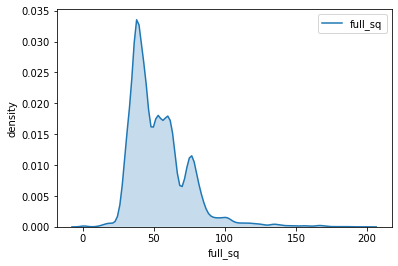

In [0]:
plot_feature_kde('full_sq', 0, 200)

In [0]:
# due to release date of the dataset
train.drop(train[train['build_year'] > 2018].index, inplace=True)

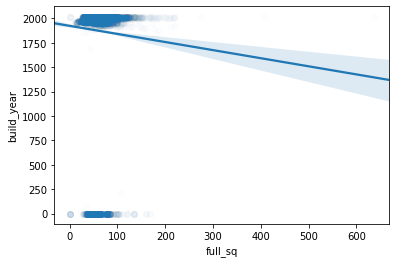

In [0]:
sns.regplot(x=train['full_sq'], y=train['build_year'], scatter_kws={'alpha':0.01})

We have a problem with build_year column to: few houses have an incorrect build_date

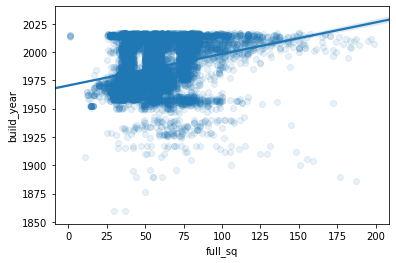

In [0]:
plot_regplot('full_sq', 'build_year', 1, 200, 1800, 2018)

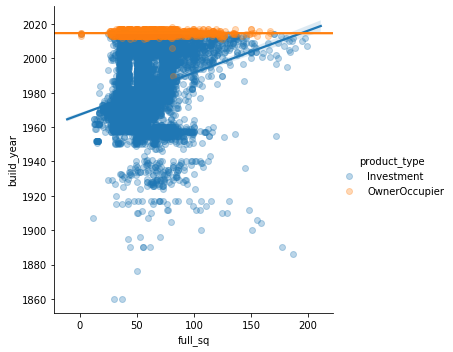

In [0]:
plot_lmplot('full_sq', 'build_year', 'product_type', 0, 200, 1800, 2018, alpha=0.3)

As we can see, the most of the houses were built between 1950 and early 2000's. Those houses mostely have full_sq between ~20 and 100 meters

In [0]:
for value in [10, 20, 30, 40, 50, 100, 150, 200, 250, 375, 500]:
    print(str(num_houses_with_bigger_column_value('full_sq', value)) + 
          ' houses have bigger full square than ' + str(value) + '.')

30438 houses have bigger full square than 10.
30304 houses have bigger full square than 20.
29359 houses have bigger full square than 30.
20875 houses have bigger full square than 40.
14839 houses have bigger full square than 50.
960 houses have bigger full square than 100.
169 houses have bigger full square than 150.
35 houses have bigger full square than 200.
15 houses have bigger full square than 250.
10 houses have bigger full square than 375.
5 houses have bigger full square than 500.


We have several houses with really big full_sq value (over 200 meters), it might be a good idea to separate them from all the other houses in the future.

In [0]:
train[train['full_sq'] < 1].iloc[:, :9]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq
id,,,,,,,,,
17935,2014-04-28,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
24299,2014-11-05,0,77.0,4.0,17.0,1.0,0.0,3.0,0.0


Let's drop uninformative rows

In [0]:
train.loc[24299, 'full_sq'] = train.loc[24299, 'life_sq']

Let's examine full_sq, life_sq and full_sq, kitch_sq pairs of columns closely

In [0]:
train[train['full_sq'] < train['life_sq']].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1085,2012-02-06,44.0,281.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6407578.10,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,no,...,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,6200000
1189,2012-02-14,9.0,44.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Veshnjaki,10518366.87,118945,0.334905,0.012339,5208,3494.0,6,5776,6766.0,7,0,2078.0,2,0,7,0,no,0,4,1,no,no,no,no,no,no,no,no,...,655.56,1074.07,864.81,0,9,7,10,1,0,0,3,9,0,4,20,5,21.94,5.56,6,226450,30,452982,102,680.00,1150.00,915.00,2,30,37,24,6,3,0,9,18,0,10,53,9,6300000
1825,2012-04-09,18.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Ljublino,17881913.61,165727,0.260653,0.133215,10809,5153.0,10,11395,11887.0,13,0,1406.0,3,0,13,1,no,0,4,3,no,no,no,yes,no,yes,no,yes,...,667.39,1130.43,898.91,3,14,17,11,3,1,0,5,8,0,0,22,1,26.28,9.05,7,106573,36,1484860,105,625.26,1063.16,844.21,10,33,34,21,6,1,0,8,23,0,3,55,9,5200000
1866,2012-04-11,30.0,178.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Presnenskoe,11638050.15,123280,0.068202,0.042032,7125,3240.0,7,6856,10602.0,9,0,1940.0,2,1,29,2,yes,3,5,84,no,no,no,yes,no,no,no,no,...,1044.11,1702.74,1373.42,28,82,82,91,64,37,9,13,15,0,7,47,3,11.60,11.82,421,7947937,56,2623000,1498,922.93,1518.57,1220.75,98,352,360,347,223,98,20,48,91,1,68,155,7,5900000
2012,2012-04-25,5.0,40.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Gol'janovo,14286990.83,157010,0.389354,0.194489,7751,5041.0,6,8004,11081.0,7,0,125.0,3,0,5,3,no,0,5,3,no,no,no,yes,no,no,no,no,...,724.00,1220.00,972.00,4,14,18,12,4,2,0,4,8,0,1,32,5,41.28,9.82,20,398612,20,719166,103,641.24,1087.63,864.43,6,34,34,21,6,2,0,10,14,0,2,50,5,5770000


In [0]:
train[train['full_sq'] < train['kitch_sq']].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8059,2013-05-21,11.0,11.0,2.0,5.0,2.0,1907.0,1.0,12.0,3.0,Investment,Hamovniki,1.007156e+07,102726,0.048791,0.000000,6374,165.0,5,7538,9337.0,8,1,4702.0,5,1,23,2,yes,2,5,87,no,no,no,yes,no,no,no,no,...,933.08,1529.12,1231.10,69,217,222,253,143,63,12,60,102,1,44,79,4,9.38,4.35,672,10742760,83,3434795,2295,908.42,1493.45,1200.94,157,539,537,562,339,135,26,133,207,1,89,161,10,2750000
9175,2013-07-12,37.0,19.0,9.0,10.0,1.0,2006.0,1.0,73.0,2.0,Investment,Kosino-Uhtomskoe,1.488362e+07,72131,0.024444,0.158249,7567,3848.0,4,5731,8687.0,5,0,NaN,1,0,4,2,no,0,0,0,no,yes,no,yes,no,no,no,no,...,833.33,1333.33,1083.33,0,0,2,4,0,0,0,2,3,0,0,2,1,14.43,7.61,2,138650,18,372816,33,712.50,1203.13,957.81,1,6,14,10,1,1,0,5,9,0,2,17,6,5600000
10371,2013-09-10,79.0,41.0,5.0,17.0,6.0,2013.0,3.0,2013.0,1.0,OwnerOccupier,Poselenie Voskresenskoe,2.149409e+07,7122,0.262459,0.017647,489,NaN,0,469,NaN,0,0,NaN,0,0,0,2,no,0,0,0,no,no,no,no,no,no,no,no,...,1000.00,1500.00,1250.00,0,0,0,3,0,0,0,1,3,1,0,5,0,17.74,4.75,0,0,5,262000,18,700.00,1125.00,912.50,2,4,4,8,0,0,0,1,7,1,0,12,1,7281225
11523,2013-10-24,38.0,23.0,11.0,14.0,5.0,1971.0,2.0,620.0,2.0,Investment,Novogireevo,4.395333e+06,94561,0.063755,0.038693,6120,2215.0,4,6533,5824.0,4,0,1015.0,2,0,7,1,no,0,5,1,no,no,no,yes,no,no,no,no,...,624.44,1077.78,851.11,1,12,21,10,1,1,0,5,7,0,6,19,4,25.31,6.36,12,332974,22,674915,86,667.47,1132.53,900.00,3,23,33,21,4,2,0,7,16,0,9,49,11,6300000
12248,2013-11-18,22.0,14.0,3.0,5.0,2.0,1970.0,1.0,33.0,1.0,Investment,Bogorodskoe,8.659075e+06,104410,0.416866,0.069660,7103,3107.0,7,6119,7277.0,9,0,NaN,1,0,8,4,no,0,2,4,no,no,no,yes,no,no,no,no,...,558.82,970.59,764.71,2,5,8,4,0,0,0,3,6,0,1,18,0,42.26,12.52,80,1499491,31,1137771,219,737.25,1245.10,991.18,15,58,68,44,30,4,0,17,30,0,7,93,3,3600000


We will figure out how to swap full_sq, life_sq and kitch_sq values in each of those bad rows to make information about the house sensible.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'scatter_kws'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


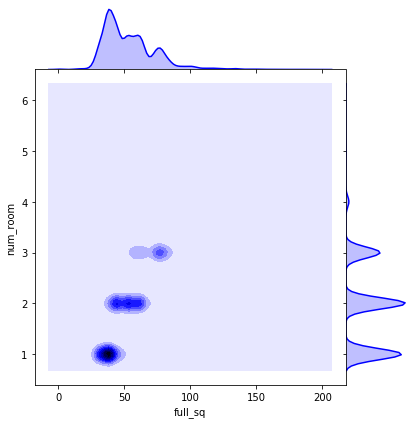

In [0]:
plot_features_jointplot('full_sq', 'num_room', 0, 200, 1, 6)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'scatter_kws'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


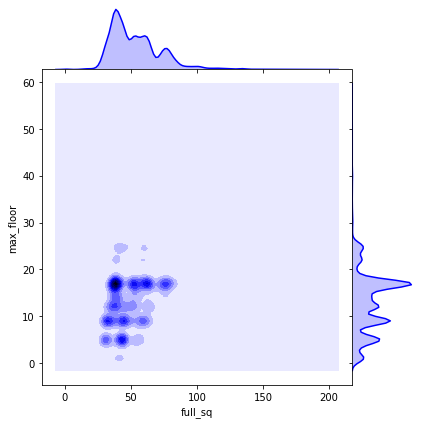

In [0]:
plot_features_jointplot('full_sq', 'max_floor', 0, 200, 1, 80)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'scatter_kws'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


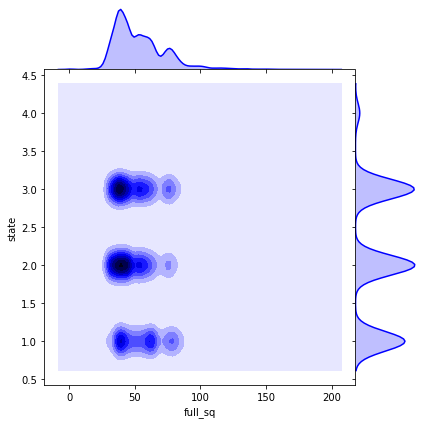

In [0]:
plot_features_jointplot('full_sq', 'state', 0, 200, 0, 10, alpha=0.3)

As we can see, full_sq doen't determine house's condition

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'scatter_kws'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


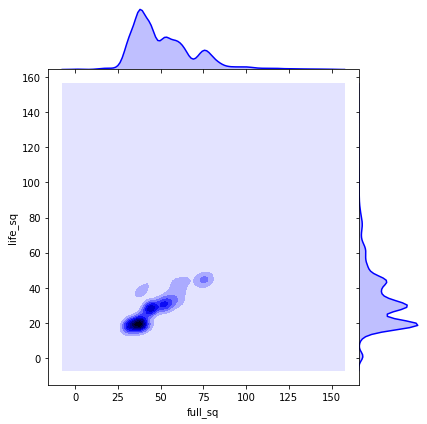

In [0]:
plot_features_jointplot('full_sq', 'life_sq', 0, 150, 0, 150)

## &emsp; life_sq

In [0]:
train['life_sq'].describe()

count    24085.000000
mean        34.404982
std         52.288751
min          0.000000
25%         20.000000
50%         30.000000
75%         43.000000
max       7478.000000
Name: life_sq, dtype: float64

In [0]:
'Number of houses with life square = 0, equals ' + str(len(train[train.life_sq == 0]))

'Number of houses with life square = 0, equals 45'

In [0]:
train[train.life_sq == 0].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
859,2012-01-19,78.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nekrasovka,11391678.48,19940,0.055644,0.243205,1706,2395.0,5,1564,7377.0,5,0,540.0,0,0,0,4,no,0,0,0,no,yes,no,no,no,no,no,no,...,833.33,1333.33,1083.33,0,0,1,2,0,0,0,0,2,0,0,1,1,14.72,7.89,0,0,5,54937,17,741.18,1235.29,988.24,0,2,7,7,1,0,0,5,6,0,0,11,2,552312
1599,2012-03-20,59.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nekrasovka,11391678.48,19940,0.055644,0.243205,1706,2395.0,5,1564,7377.0,5,0,540.0,0,0,0,4,no,0,0,0,no,yes,no,no,no,no,no,no,...,833.33,1333.33,1083.33,0,0,1,2,0,0,0,0,2,0,0,1,1,14.04,7.89,0,0,5,54937,15,753.33,1266.67,1010.00,0,1,7,6,1,0,0,4,6,0,0,7,1,338570
2781,2012-07-06,38.0,0.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nekrasovka,11391678.48,19940,0.055644,0.243205,1706,2395.0,5,1564,7377.0,5,0,540.0,0,0,0,4,no,0,0,0,no,yes,no,no,no,no,no,no,...,633.33,1083.33,858.33,0,1,3,2,0,0,0,1,2,0,0,1,1,14.00,7.89,1,26950,5,54937,21,661.90,1142.86,902.38,0,3,11,6,1,0,0,4,6,0,0,10,1,675205
3429,2012-08-31,71.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nekrasovka,11391678.48,19940,0.055644,0.243205,1706,2395.0,5,1564,7377.0,5,0,540.0,0,0,0,4,no,0,0,0,no,yes,no,no,no,no,no,no,...,633.33,1083.33,858.33,0,1,3,2,0,0,0,1,2,0,0,1,1,13.85,7.89,1,26950,5,54937,21,661.90,1142.86,902.38,0,3,11,6,1,0,0,4,6,0,0,10,1,1438647
3803,2012-09-24,57.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Poselenie Moskovskij,40366999.51,21819,0.492840,0.075779,1497,NaN,0,1437,NaN,0,0,NaN,0,0,3,3,no,0,2,3,no,no,no,no,no,no,no,no,...,500.00,1000.00,750.00,0,0,1,0,0,0,0,0,3,0,0,2,0,46.77,4.56,1,117300,3,139300,14,661.54,1153.85,907.69,1,2,7,3,1,0,0,1,7,0,0,8,0,5049071


We can calculate life_sq if we know full_sq or kitch_sq. Later we'll swap life_sq, full_sq and kitch_sq in some rows to make all the rows sensible.

In [0]:
def calculate_life_square (row):
  if row['life_sq'] > 0:
    return row['life_sq']
  elif row['life_sq'] == 0:
    if row['kitch_sq'] >= 0:
      return row['full_sq'] - row['kitch_sq']
    else:
      return row['full_sq']
  else:
    if row['kitch_sq'] >= 0:
      return row['full_sq'] - row['kitch_sq']
    else:
      return row['full_sq']

In [0]:
train['life_sq'] = train.apply(calculate_life_square, axis = 1)

In [0]:
for value in [10, 20, 50, 100, 150, 175, 200, 250, 375, 500]:
    print(str(num_houses_with_bigger_column_value('life_sq', value)) + 
          ' houses have bigger life square than ' + str(value) + '.')

30028 houses have bigger life square than 10.
23609 houses have bigger life square than 20.
7015 houses have bigger life square than 50.
490 houses have bigger life square than 100.
107 houses have bigger life square than 150.
32 houses have bigger life square than 175.
20 houses have bigger life square than 200.
16 houses have bigger life square than 250.
10 houses have bigger life square than 375.
5 houses have bigger life square than 500.


In [0]:
train['life_sq/full_sq'] = train.apply(lambda x: (x['life_sq'] + 1) / (x['full_sq'] + 1) if (not pd.isnull(x['life_sq']) and x['full_sq'] != 0 and not pd.isnull(x['full_sq'])) else 0.7 ,axis=1)
train['back_life_sq_ratio'] = 1 / train['life_sq/full_sq']

In [0]:
train[train['life_sq'] > 200].head(10)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,...,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
129,2011-10-15,325.0,325.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Ivanovskoe,1.020722e+07,122862,0.512707,0.000170,6027,2697.0,7,5992,9439.0,8,1,NaN,1,0,5,0,no,0,1,0,no,no,no,yes,no,no,no,no,...,857.32,1,11,19,9,1,1,0,5,7,0,6,19,3,26.67,5.24,11,336274,20,614676,87,604.76,1041.67,823.21,3,26,36,18,3,1,0,7,14,0,9,44,10,5000000,1.003077,0.996933
1085,2012-02-06,44.0,281.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,no,...,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,6200000,6.409091,0.156028
3599,2012-09-12,388.0,388.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Nekrasovka,1.139168e+07,19940,0.055644,0.243205,1706,2395.0,5,1564,7377.0,5,0,540.0,0,0,0,4,no,0,0,0,no,yes,no,no,no,no,no,no,...,1083.33,0,0,1,2,0,0,0,0,2,0,0,1,1,13.50,7.69,0,0,3,43437,14,771.43,1285.71,1028.57,0,1,6,6,1,0,0,4,6,0,0,4,1,3899400,1.002577,0.997429
4388,2012-10-25,73.0,426.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Vojkovskoe,5.333221e+06,64931,0.074077,0.169091,3905,1579.0,6,3856,5838.0,8,0,NaN,2,0,5,2,no,0,5,10,no,no,no,no,no,no,no,yes,...,853.33,13,39,34,24,6,2,0,4,7,0,0,29,5,15.32,13.63,82,2038109,45,1388959,304,682.55,1145.45,914.00,29,89,91,70,17,8,0,14,25,0,3,88,14,11918400,5.849315,0.170960
5731,2013-01-21,210.0,210.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Tverskoe,7.307411e+06,75377,0.065444,0.000078,4237,1874.0,4,6398,6772.0,4,1,1046.0,3,2,29,16,yes,10,23,141,no,no,no,yes,yes,no,no,yes,...,1183.72,81,376,372,330,208,91,20,53,102,1,56,93,5,7.16,11.90,736,11040453,98,4453835,2443,883.89,1456.55,1170.22,153,607,592,582,346,138,25,123,218,2,96,184,11,71033632,1.004762,0.995261
9240,2013-07-16,47.0,301.0,4.0,12.0,1.0,1973.0,2.0,6.0,2.0,Investment,Birjulevo Zapadnoe,8.464344e+06,85721,0.075206,0.521867,5226,2901.0,4,6149,5226.0,4,0,NaN,0,0,2,0,no,0,0,0,yes,yes,no,yes,no,no,no,no,...,843.75,1,5,6,4,1,0,0,2,4,0,1,12,0,16.04,13.68,9,249851,32,1508615,72,737.50,1226.56,982.03,8,19,18,18,8,1,0,5,13,0,2,30,5,5600000,6.425532,0.155629
9259,2013-07-17,77.0,458.0,12.0,16.0,1.0,1996.0,3.0,10.0,3.0,Investment,Jasenevo,2.481385e+07,174831,0.683844,0.037178,10712,4172.0,7,11217,10559.0,7,0,2300.0,1,0,7,7,no,0,7,1,no,no,no,yes,no,no,no,no,...,745.83,1,11,7,5,1,0,0,2

In [0]:
train[train['life_sq'] > train['full_sq']][['full_sq', 'life_sq', 'price_doc', 'life_sq/full_sq']]

,full_sq,life_sq,price_doc,life_sq/full_sq
id,,,,
1085,44.0,281.0,6200000,6.409091
1189,9.0,44.0,6300000,5.000000
1825,18.0,38.0,5200000,2.166667
1866,30.0,178.0,5900000,5.966667
2012,5.0,40.0,5770000,8.200000
4388,73.0,426.0,11918400,5.849315
6339,37.0,191.0,5400000,5.189189
6534,80.0,88.0,13801229,1.112500
6996,73.0,77.0,6290256,1.068493


In [0]:
train[(train['life_sq/full_sq'] > 2) & (train['life_sq'] > 200)]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,...,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1085,2012-02-06,44.0,281.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,no,...,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,6200000,6.409091,0.156028
4388,2012-10-25,73.0,426.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Vojkovskoe,5.333221e+06,64931,0.074077,0.169091,3905,1579.0,6,3856,5838.0,8,0,NaN,2,0,5,2,no,0,5,10,no,no,no,no,no,no,no,yes,...,853.33,13,39,34,24,6,2,0,4,7,0,0,29,5,15.32,13.63,82,2038109,45,1388959,304,682.55,1145.45,914.00,29,89,91,70,17,8,0,14,25,0,3,88,14,11918400,5.849315,0.170960
9240,2013-07-16,47.0,301.0,4.0,12.0,1.0,1973.0,2.0,6.0,2.0,Investment,Birjulevo Zapadnoe,8.464344e+06,85721,0.075206,0.521867,5226,2901.0,4,6149,5226.0,4,0,NaN,0,0,2,0,no,0,0,0,yes,yes,no,yes,no,no,no,no,...,843.75,1,5,6,4,1,0,0,2,4,0,1,12,0,16.04,13.68,9,249851,32,1508615,72,737.50,1226.56,982.03,8,19,18,18,8,1,0,5,13,0,2,30,5,5600000,6.425532,0.155629
9259,2013-07-17,77.0,458.0,12.0,16.0,1.0,1996.0,3.0,10.0,3.0,Investment,Jasenevo,2.481385e+07,174831,0.683844,0.037178,10712,4172.0,7,11217,10559.0,7,0,2300.0,1,0,7,7,no,0,7,1,no,no,no,yes,no,no,no,no,...,745.83,1,11,7,5,1,0,0,2,8,0,0,7,4,45.66,8.45,5,149924,27,755176,53,596.08,1029.41,812.75,2,18,20,9,4,0,0,5,22,0,0,18,7,13750000,5.961039,0.167756
9649,2013-08-06,82.0,802.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Chertanovo Juzhnoe,9.282439e+06,143661,0.153279,0.127376,8356,3844.0,6,8429,8810.0,7,0,NaN,3,0,3,4,no,0,9,3,no,no,no,no,no,no,no,no,...,901.72,2,11,6,9,3,0,0,2,7,0,0,9,3,30.93,13.75,11,579851,40,1139469,80,668.00,1120.00,894.00,5,27,22,18,7,1,0,7,16,0,0,34,5,12031350,9.792683,0.102117
13549,2013-12-30,79.0,7478.0,8.0,17.0,1.0,2014.0,3.0,1.0,1.0,OwnerOccupier,Poselenie Voskresenskoe,2.149409e+07,7122,0.262459,0.017647,489,NaN,0,469,NaN,0,0,NaN,0,0,0,2,no,0,0,0,no,no,no,no,no,no,no,no,...,1250.00,0,0,0,3,0,0,0,1,3,1,0,5,0,17.92,4.75,0,0,5,262000,18,700.00,1125.00,912.50,2,4,4,8,0,0,0,1,7,1,0,12,1,7705000,94.670886,0.010563
13632,2014-01-10,45.0,259.0,5.0,5.0,1.0,1970.0,2.0,5.0,NaN,Investment,Poselenie Moskovskij,4.036700e+07,21819,0.492840,0.075779,1497,NaN,0,1437,NaN,0,0,NaN,0,0,3,3,no,0,2,3,no,no,no,no,no,no,no,no,...,750.00,0,0,1,0,0,0,0,0,3,0,0,2,0,46.77,4.56,1,117300,

There is definitely interconnection between life_sq/full_sq, full_sq, life_sq columns and the way we should decide wether real full_sq equals full_sq or life_sq.

In [0]:
def change_life_sq (row):
    if row['life_sq'] > 100:
        return row['full_sq']
    elif row['life_sq/full_sq'] > 1.3:
        return row['life_sq'] - row['full_sq']
    elif row['full_sq'] < row['life_sq']:
        return row['full_sq']
    return row['life_sq']

def change_full_sq (row):
    if row['life_sq'] > 100:
        return row['full_sq']
    elif row['life_sq/full_sq'] > 1.3:
        return row['life_sq']
    elif row['full_sq'] < row['life_sq']:
        return row['life_sq']
    return row['full_sq']

def account_kitch_sq (row):
    if row['kitch_sq'] >= 0 and row['kitch_sq'] < row['full_sq_help']:
        return row['full_sq_help'] - row['kitch_sq']
    return row['life_sq_help']

In [0]:
train_help = train[['full_sq', 'life_sq', 'kitch_sq', 'life_sq/full_sq']].copy()
train_help['life_sq_help'] = train_help.apply(change_life_sq, axis=1)
train_help['full_sq_help'] = train_help.apply(change_full_sq, axis=1)
train_help['life_sq_help'] = train_help.apply(account_kitch_sq, axis=1)

Let's examine the results

In [0]:
train_help[train_help['life_sq'] > train_help['full_sq']]

,full_sq,life_sq,kitch_sq,life_sq/full_sq,life_sq_help,full_sq_help
id,,,,,,
1085,44.0,281.0,NaN,6.409091,44.0,44.0
1189,9.0,44.0,NaN,5.000000,35.0,44.0
1825,18.0,38.0,NaN,2.166667,20.0,38.0
1866,30.0,178.0,NaN,5.966667,30.0,30.0
2012,5.0,40.0,NaN,8.200000,35.0,40.0
4388,73.0,426.0,NaN,5.849315,73.0,73.0
6339,37.0,191.0,NaN,5.189189,37.0,37.0
6534,80.0,88.0,NaN,1.112500,80.0,88.0
6996,73.0,77.0,NaN,1.068493,73.0,77.0


in my opinion everything went quite well. This funtion will be included in the final Pipeline.

In [0]:
train[['full_sq', 'life_sq']] = train_help[['full_sq_help', 'life_sq_help']]

Let's recalculate new life_sq/full_sq and back_life_sq_ratio.

In [0]:
train['life_sq/full_sq'] = train.apply(lambda x: (x['life_sq'] + 1) / (x['full_sq'] + 1) \
 if (not pd.isnull(x['life_sq']) and x['full_sq'] != 0 and not pd.isnull(x['full_sq'])) else 0.85 ,axis=1)
train['back_life_sq_ratio'] = 1 / train['life_sq/full_sq']

## &emsp; kitch_sq

In [0]:
train['kitch_sq'].describe()

count    20897.000000
mean         6.399244
std         28.267325
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: kitch_sq, dtype: float64

As we can see, there are some houses with extremely big kitch_sq value, lets count those houses.

In [0]:
for value in [10, 20, 30, 40, 50, 60, 80, 100, 150, 200]:
    print(str(num_houses_with_bigger_column_value('kitch_sq', value)) + 
          ' houses have bigger kitch square than ' + str(value) + '.')

1637 houses have bigger kitch square than 10.
111 houses have bigger kitch square than 20.
75 houses have bigger kitch square than 30.
53 houses have bigger kitch square than 40.
41 houses have bigger kitch square than 50.
29 houses have bigger kitch square than 60.
14 houses have bigger kitch square than 80.
9 houses have bigger kitch square than 100.
5 houses have bigger kitch square than 150.
5 houses have bigger kitch square than 200.


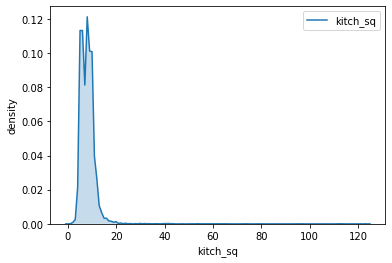

In [0]:
plot_feature_kde('kitch_sq', 1, 150)

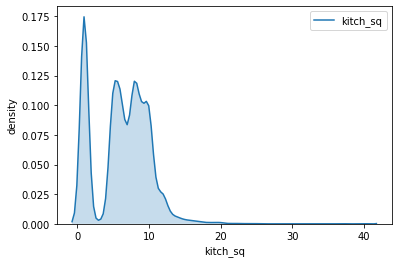

In [0]:
plot_feature_kde('kitch_sq', 1, 40)

In [0]:
train[train['kitch_sq'] > 100]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,...,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8952,2013-07-04,123.0,123.0,3.0,10.0,2.0,2013.0,3.0,123.0,3.0,OwnerOccupier,Poselenie Voskresenskoe,2.149409e+07,7122,0.262459,0.017647,489,NaN,0,469,NaN,0,0,NaN,0,0,0,2,no,0,0,0,no,no,no,no,no,no,no,no,...,400.00,0,1,0,0,0,0,0,0,4,0,0,0,0,23.42,2.04,0,0,0,0,7,1328.57,2142.86,1735.71,0,1,1,2,1,2,0,0,10,0,0,2,0,8287230,1.000000,1.000000
10371,2013-09-10,79.0,41.0,5.0,17.0,6.0,2013.0,3.0,2013.0,1.0,OwnerOccupier,Poselenie Voskresenskoe,2.149409e+07,7122,0.262459,0.017647,489,NaN,0,469,NaN,0,0,NaN,0,0,0,2,no,0,0,0,no,no,no,no,no,no,no,no,...,1250.00,0,0,0,3,0,0,0,1,3,1,0,5,0,17.74,4.75,0,0,5,262000,18,700.00,1125.00,912.50,2,4,4,8,0,0,0,1,7,1,0,12,1,7281225,0.525000,1.904762
11523,2013-10-24,38.0,23.0,11.0,14.0,5.0,1971.0,2.0,620.0,2.0,Investment,Novogireevo,4.395333e+06,94561,0.063755,0.038693,6120,2215.0,4,6533,5824.0,4,0,1015.0,2,0,7,1,no,0,5,1,no,no,no,yes,no,no,no,no,...,851.11,1,12,21,10,1,1,0,5,7,0,6,19,4,25.31,6.36,12,332974,22,674915,86,667.47,1132.53,900.00,3,23,33,21,4,2,0,7,16,0,9,49,11,6300000,0.615385,1.625000
13120,2013-12-14,31.0,19.0,5.0,1.0,1.0,NaN,1.0,1970.0,3.0,Investment,Izmajlovo,1.504557e+07,102828,0.637399,0.006076,4992,1313.0,4,5285,4339.0,6,0,645.0,6,0,16,3,no,0,6,0,no,no,no,yes,no,no,no,no,...,897.78,5,32,28,19,10,1,0,7,9,0,4,42,2,21.80,16.81,112,1876406,46,1043695,294,688.89,1170.25,929.57,15,79,105,63,27,5,0,27,44,0,12,117,12,3650000,0.625000,1.600000
20056,2014-06-24,112.0,112.0,3.0,3.0,1.0,2015.0,3.0,112.0,3.0,OwnerOccupier,Poselenie Sosenskoe,6.677245e+07,9553,0.336177,0.072158,656,NaN,0,629,NaN,0,0,NaN,0,0,1,0,no,0,0,1,no,no,no,no,no,yes,no,no,...,787.50,0,1,2,1,0,0,0,1,3,0,0,0,0,35.63,11.85,6,233752,5,473076,28,796.15,1326.92,1061.54,2,9,7,5,3,2,0,2,11,0,0,6,3,8200031,1.000000,1.000000
21418,2014-08-11,43.0,43.0,3.0,1.0,1.0,2014.0,1.0,2014.0,1.0,OwnerOccupier,Poselenie Sosenskoe,6.677245e+07,9553,0.336177,0.072158,656,NaN,0,629,NaN,0,0,NaN,0,0,1,0,no,0,0,1,no,no,no,no,no,yes,no,no,...,2312.50,0,0,1,0,1,2,0,0,4,0,0,1,0,33.58,8.62,1,85159,1,189076,12,1108.33,1833.33,1470.83,0,1,4,3,2,2,0,0,12,1,0,6,1,3801200,1.000000,1.000000
27934,2015-02-16,112.0,112.0,3.0,3.0,1.0,2015.0,3.0,112.0,3.0,OwnerOccupier,Poselenie Sosenskoe,6.677245e+07,9553,0.336177,0.072158,656,NaN,0,629,NaN,0,0,NaN,0,0,1,0,no,0,0,1,no,no,no,no,no,yes,no,no,...,787.50,0,1,2,1,0,0,0,1,3,0,0,0,0,35.63,11.85,6,233752,5,473076,28,796.15,13

As we can see, all of those houses have incorrect kitch_sq. We can calculate their kitch_sq = full_sq - life_sq. Since we've already correctly calculated life_sq, we can calculate kitch_sq.

In [0]:
train['kitch_sq'] = train.apply(lambda x: x['full_sq'] - x['life_sq'] , axis = 1)

In [0]:
train['life_sq/kitch_sq'] = (train['life_sq'] + 1) / (train['kitch_sq'] + 1)

In [0]:
print(len(train[train['kitch_sq'] > train['life_sq']].index), 'houses have kitch_sq > life_sq.')

796 houses have kitch_sq > life_sq.


In [0]:
train[train['kitch_sq'] > train['life_sq']].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,...,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio,life_sq/kitch_sq
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
35,2011-09-28,39.0,19.0,1.0,NaN,NaN,NaN,NaN,20.0,NaN,Investment,Staroe Krjukovo,4.389199e+06,28537,0.033226,0.130123,1908,1860.0,2,1986,5038.0,3,0,NaN,0,0,1,0,no,0,0,0,no,no,no,no,no,no,no,no,...,0,7,4,3,0,0,0,0,2,0,2,8,1,28.71,8.17,3,51038,7,49700,14,507.14,857.14,682.14,0,7,4,3,0,0,0,1,3,0,2,8,2,3900000,0.500000,2.000000,0.952381
72,2011-10-05,64.0,28.0,10.0,NaN,NaN,NaN,NaN,36.0,NaN,Investment,Ochakovo-Matveevskoe,1.752651e+07,118843,0.133373,0.309479,7454,1830.0,2,7715,6484.0,3,0,990.0,0,0,7,3,no,0,6,4,yes,no,no,no,no,no,no,no,...,4,6,16,7,6,1,0,2,4,0,1,14,2,23.09,10.71,23,687420,34,727345,153,790.71,1321.43,1056.07,13,34,45,37,19,5,0,5,16,0,4,46,5,2630000,0.446154,2.241379,0.783784
73,2011-10-06,66.0,17.0,2.0,NaN,NaN,NaN,NaN,49.0,NaN,Investment,Taganskoe,8.087656e+06,116742,0.048011,0.007659,6694,3318.0,5,7077,9748.0,10,0,2301.0,3,1,24,1,yes,1,19,56,no,no,no,yes,no,no,no,no,...,39,148,162,158,62,16,2,54,76,1,15,55,5,3.99,20.46,563,7659490,112,4208173,1736,839.67,1388.96,1114.31,115,427,448,430,226,80,10,126,200,2,69,166,16,2600000,0.268657,3.722222,0.360000
80,2011-10-07,133.0,64.0,2.0,NaN,NaN,NaN,NaN,69.0,NaN,Investment,Izmajlovo,1.504557e+07,102828,0.637399,0.006076,4992,1313.0,4,5285,4339.0,6,0,645.0,6,0,16,3,no,0,6,0,no,no,no,yes,no,no,no,no,...,2,16,16,12,3,1,0,4,7,0,1,26,5,35.19,9.69,16,336612,21,1034166,101,652.63,1110.53,881.58,6,30,36,21,6,2,0,9,17,0,3,54,7,17600000,0.485075,2.061538,0.928571
86,2011-10-07,43.0,21.0,7.0,NaN,NaN,NaN,NaN,22.0,NaN,Investment,Babushkinskoe,4.934147e+06,86206,0.116400,0.122190,4300,1578.0,3,4724,5461.0,3,0,1308.0,1,0,6,2,no,0,3,2,no,no,no,no,no,no,no,yes,...,9,19,18,15,4,0,0,9,8,0,0,39,1,19.05,8.69,27,476375,39,3754476,141,644.80,1096.00,870.40,16,42,44,27,11,1,0,14,18,2,3,71,4,6700000,0.500000,2.000000,0.956522


In my opinion, I can't imagine a real house with kitch_sq much bigger than life_sq. We'll see how we can swap kitch_sq and life_sq according to life_sq/kitch_sq ratio.

In [0]:
train[train['life_sq/kitch_sq'] < 1].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,...,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio,life_sq/kitch_sq
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
35,2011-09-28,39.0,19.0,1.0,NaN,NaN,NaN,NaN,20.0,NaN,Investment,Staroe Krjukovo,4.389199e+06,28537,0.033226,0.130123,1908,1860.0,2,1986,5038.0,3,0,NaN,0,0,1,0,no,0,0,0,no,no,no,no,no,no,no,no,...,0,7,4,3,0,0,0,0,2,0,2,8,1,28.71,8.17,3,51038,7,49700,14,507.14,857.14,682.14,0,7,4,3,0,0,0,1,3,0,2,8,2,3900000,0.500000,2.000000,0.952381
72,2011-10-05,64.0,28.0,10.0,NaN,NaN,NaN,NaN,36.0,NaN,Investment,Ochakovo-Matveevskoe,1.752651e+07,118843,0.133373,0.309479,7454,1830.0,2,7715,6484.0,3,0,990.0,0,0,7,3,no,0,6,4,yes,no,no,no,no,no,no,no,...,4,6,16,7,6,1,0,2,4,0,1,14,2,23.09,10.71,23,687420,34,727345,153,790.71,1321.43,1056.07,13,34,45,37,19,5,0,5,16,0,4,46,5,2630000,0.446154,2.241379,0.783784
73,2011-10-06,66.0,17.0,2.0,NaN,NaN,NaN,NaN,49.0,NaN,Investment,Taganskoe,8.087656e+06,116742,0.048011,0.007659,6694,3318.0,5,7077,9748.0,10,0,2301.0,3,1,24,1,yes,1,19,56,no,no,no,yes,no,no,no,no,...,39,148,162,158,62,16,2,54,76,1,15,55,5,3.99,20.46,563,7659490,112,4208173,1736,839.67,1388.96,1114.31,115,427,448,430,226,80,10,126,200,2,69,166,16,2600000,0.268657,3.722222,0.360000
80,2011-10-07,133.0,64.0,2.0,NaN,NaN,NaN,NaN,69.0,NaN,Investment,Izmajlovo,1.504557e+07,102828,0.637399,0.006076,4992,1313.0,4,5285,4339.0,6,0,645.0,6,0,16,3,no,0,6,0,no,no,no,yes,no,no,no,no,...,2,16,16,12,3,1,0,4,7,0,1,26,5,35.19,9.69,16,336612,21,1034166,101,652.63,1110.53,881.58,6,30,36,21,6,2,0,9,17,0,3,54,7,17600000,0.485075,2.061538,0.928571
86,2011-10-07,43.0,21.0,7.0,NaN,NaN,NaN,NaN,22.0,NaN,Investment,Babushkinskoe,4.934147e+06,86206,0.116400,0.122190,4300,1578.0,3,4724,5461.0,3,0,1308.0,1,0,6,2,no,0,3,2,no,no,no,no,no,no,no,yes,...,9,19,18,15,4,0,0,9,8,0,0,39,1,19.05,8.69,27,476375,39,3754476,141,644.80,1096.00,870.40,16,42,44,27,11,1,0,14,18,2,3,71,4,6700000,0.500000,2.000000,0.956522


In [0]:
train_help = train[['kitch_sq', 'life_sq', 'full_sq', 'life_sq/kitch_sq']].copy()
train_help['life_sq_help'] = train_help.apply(lambda x: x['kitch_sq'] if x['life_sq/kitch_sq'] < 1 \
                                              else x['life_sq'], axis=1)
train_help['kitch_sq_help'] = train_help.apply(lambda x: x['life_sq'] if x['life_sq/kitch_sq'] < 1 \
                                              else x['kitch_sq'], axis=1)
train[['life_sq', 'kitch_sq']]= train_help[['life_sq_help', 'kitch_sq_help']]

Let's check that we've done everything correctly: there are no NANs in the full_sq, life_sq and kitch_sq columns.

In [0]:
train[['full_sq', 'life_sq', 'kitch_sq']].isna().sum()

full_sq     0
life_sq     0
kitch_sq    0
dtype: int64

In [0]:
train['life_sq/full_sq'] = (train['life_sq'] + 1) / (train['full_sq'] + 1)
train['life_sq/kitch_sq'] = (train['life_sq'] + 1) / (train['kitch_sq'] + 1)
train['back_life_sq_ratio'] = 1 / train['life_sq/full_sq']
train['back_kitch_sq_ratio'] = 1 / train['life_sq/kitch_sq'] 

Let's examine life_sq and kitch_sq distributions now when we've filled in NANs and swaped some values. 

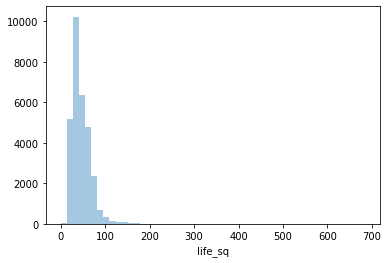

In [0]:
  plot_distplot('life_sq')

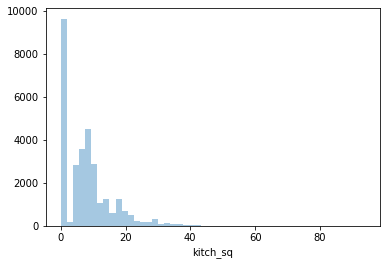

In [0]:
plot_distplot('kitch_sq')

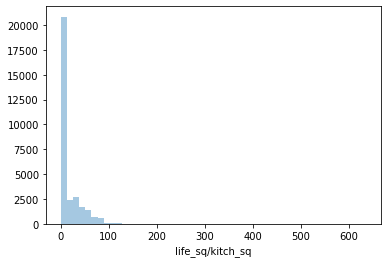

In [0]:
plot_distplot('life_sq/kitch_sq')

As we can see, we still have lots of houses with kitch_sq around zero.

In [0]:
print(len(train[train['kitch_sq'] < 5]), 'houses have kitch_sq less than 5 meters.')

9966 houses have kitch_sq less than 5 meters.


In [0]:
print(len(train[train['kitch_sq'] < 1]), 'houses have kitch_sq less than 1 meter.')

4673 houses have kitch_sq less than 1 meter.


In [0]:
train[train['kitch_sq'] < 1].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,...,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio,life_sq/kitch_sq,back_kitch_sq_ratio
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2011-09-05,77.0,77.0,4.0,NaN,NaN,NaN,NaN,0.0,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,no,0,10,93,no,no,no,yes,yes,no,no,no,...,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14,16331452,1.0,1.0,78.0,0.012821
8,2011-09-09,44.0,44.0,5.0,NaN,NaN,NaN,NaN,0.0,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,no,...,21,15,11,3,1,0,3,4,0,0,18,2,15.80,11.44,24,711780,45,2197401,143,709.09,1189.39,949.24,11,37,46,36,9,4,0,11,18,1,0,47,4,2000000,1.0,1.0,45.0,0.022222
14,2011-09-19,31.0,31.0,4.0,NaN,NaN,NaN,NaN,0.0,NaN,Investment,Presnenskoe,1.163805e+07,123280,0.068202,0.042032,7125,3240.0,7,6856,10602.0,9,0,1940.0,2,1,29,2,yes,3,5,84,no,no,no,yes,no,no,no,no,...,91,92,109,81,44,11,15,19,0,10,47,4,11.73,11.85,441,8143924,61,2817760,1615,935.24,1538.23,1236.74,111,377,377,366,254,108,22,57,102,1,72,166,7,5200000,1.0,1.0,32.0,0.031250
22,2011-09-22,39.0,39.0,7.0,NaN,NaN,NaN,NaN,0.0,NaN,Investment,Juzhnoe Tushino,7.887684e+06,104434,0.222646,0.188784,5989,2707.0,3,6137,6340.0,4,0,NaN,0,0,10,1,no,0,1,4,no,no,no,no,no,no,no,no,...,24,27,18,6,3,0,5,3,0,1,31,5,19.76,11.45,46,1425767,46,1413963,225,690.59,1160.89,925.74,23,60,68,53,18,3,0,12,14,0,1,64,9,5200000,1.0,1.0,40.0,0.025000
38,2011-09-30,27.0,27.0,4.0,NaN,NaN,NaN,NaN,0.0,NaN,Investment,Caricyno,8.287309e+06,125354,0.071120,0.265089,5797,3390.0,4,5288,5631.0,5,0,1937.0,3,0,6,4,no,0,2,0,no,no,no,yes,no,no,no,no,...,4,11,6,4,1,0,2,6,0,1,15,3,16.78,19.06,17,826151,44,1952964,139,633.59,1082.03,857.81,11,42,48,27,10,1,0,6,20,1,3,53,9,4300000,1.0,1.0,28.0,0.035714


Let's examine kitch_sq and life_sq / kitch_sq median.

In [0]:
train['kitch_sq'].median()

7.0

In [0]:
train['life_sq/kitch_sq'].median()

5.818181818181818

In [0]:
train['life_sq/kitch_sq'].describe()

count    30468.000000
mean        16.831630
std         23.653163
min          1.000000
25%          3.222222
50%          5.818182
75%         24.500000
max        635.000000
Name: life_sq/kitch_sq, dtype: float64

In [0]:
train['life_sq/full_sq'].describe()

count    30468.000000
mean         0.842544
std          0.142766
min          0.503650
25%          0.782609
50%          0.868421
75%          0.980392
max          1.000000
Name: life_sq/full_sq, dtype: float64

In [0]:
train['life_sq/full_sq'].median()

0.868421052631579

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'scatter_kws'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


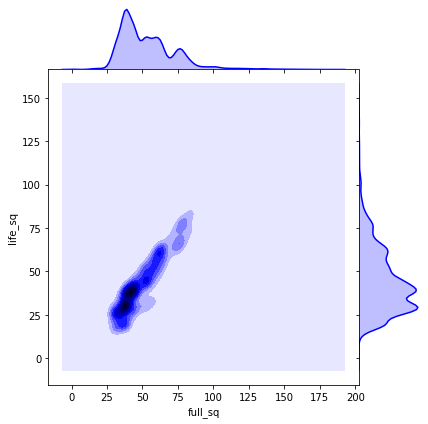

In [0]:
plot_features_jointplot('full_sq', 'life_sq', 1, 200, 1, 150)

As we've guessed, the mean life_sq/full_sq values is ~0.85. 